In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.covariance import EmpiricalCovariance, EllipticEnvelope, MinCovDet
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.svm import OneClassSVM



# incase we want to try some cleaning steps to see if it improves the model
import Clean_Function_Helpers as cfh

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

SEED = 1111

In [3]:
# helper functions
def get_weights(ser):
    """
    Weighs observations so that they can be
    sampled in such a way as to result in even distributions.
    Used in following function to oversample minority class of a dataset.
    """
    vcs = ser.value_counts()
    class_labels = vcs.index.tolist()
    class_sizes = vcs.values
    nclasses = len(class_labels)
    class_weights = dict(zip(class_labels,(nclasses**-1/class_sizes)))
    return class_weights


def pr_curve(y_actual, y_pred, digit_prec=2):
    '''
    PLOTS THE PRECISION VS RECAL OF A LOG REG ESTIMATOR
    OVER A RANGE OF THRESHOLDS

    Y_PRED MUST BE PREDICTED PROBABILITY VECTOR OF ONE CLASS (EG PROBS[:,1])
    MUST ALL BE OF TYPE INT OR FLOAT

    RETURNS: recalls, precisions, thresholds

    '''
    threshvec = np.unique(np.round(y_pred,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(y_actual[y_pred>=thresh])
        fpvec[i] = sum(1-y_actual[y_pred>=thresh])
        fnvec[i] = sum(y_actual[y_pred<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("precision")
    plt.ylabel("recall")
    return (recallvec, precisionvec, threshvec)

def calc_f1(recalls, precisions):
    return (2*recalls*precisions)/(recalls + precisions)

## Overview

Taking two different approaches. 

    1. Try to model the difference between real and fraudulent charges.
        - Classifiers like Logistic Regression, NaiveBayes, Tree Ensembles etc
        - Sampling approaches over vs undersampling
    2. Try to identify core boundary of real charges and identify anything outside this boundary as fraudulent.
        - Covariance estimates, Local Outlier Factor, Clustering, One Class SVM

### Read Data

In [4]:
df = pd.read_csv('creditcard.csv')
df.Class.value_counts()/df.Class.value_counts().sum()

0    0.998273
1    0.001727
Name: Class, dtype: float64

### Classifiers

Here we cross-validate a few classifiers on the raw data via the following steps:

    1. Take a small sample of the data set for training. This both reduces training time and gives us a large test set for validation. Make sure the Class proportions are the same in the sample as the test dataset.
        * Note that the training set has only about 100 fraudulent cases in it.
    2. Fit a classifier using Cross-validated grid search on the training set.
    3. Use the final estimator to make predictions on the test set and calculate precision and recall.

In [5]:
def get_sample(df, n=None, frac=None, n_oversample=False, n_undersample=False):
    """
    Generate Train and Test samples of specified size with the option
    to oversample or undersample.
    """
    if n_oversample:
        # split out classes
        c0 = df[df.Class==0].sample(n = n_oversample//2, random_state = SEED)
        # sample half of the minority class
        c1 = df[df.Class==1].sample(frac=0.5, random_state = SEED)
        # sample the minority class W REPLACEMENT
        c1 = c1.sample(n_oversample//2, replace=True, random_state=SEED)
        # join them together
        train = pd.concat([c0,c1])
        test = df[~df.index.isin(train.index)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test
    elif n_undersample:
        # take `n_undersample` observations from each class
        idx0 = df[df.Class==0].sample(n = n_undersample, random_state = SEED).index.tolist()
        idx1 = df[df.Class==1].sample(n = n_undersample, random_state = SEED).index.tolist()
        tidx = idx0 + idx1
        train = df.loc[tidx].copy() 
        test = df[~df.index.isin(tidx)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test
    else:
        train = df.sample(n=n, frac=frac, random_state=SEED)
        test = df[~df.index.isin(train.index)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test

def evaluate_classifier(train_data, test_data, clf, params, cv=4, scoring='roc_auc'):
    '''
    Takes grid searches parameters for a passed classifier and evaluates 
    on the test set.
    '''
    x = train_data.drop(['Time','Class'], axis=1)
    y = train_data.Class

    # grid search parameters
    grid = GridSearchCV(clf, params, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(x,y)
    print('Best Params:', grid.best_params_)
    print('Best Score:', grid.best_score_)

    # get best estimator and scores
    mod = grid.best_estimator_
    # run predictions on test set
    pred_proba = mod.predict_proba(test_data[x.columns])
    preds = mod.predict(test_data[x.columns])
    
    # plot pr curve
    r,p,t = pr_curve(test_data.Class, pred_proba[:,1]);
    
    # find threshold that maximizes f1 score
    idx = np.argmax(calc_f1(r[:-1],p[:-1]))
    print('F1:', calc_f1(r[idx], p[idx]))
    print('Recall:', r[idx])
    print('Precision:', p[idx])
    print('Threshold:', t[idx])
    return mod, x, y

In [6]:
# Train and Test Samples
train_reg, test_reg = get_sample(df, frac=0.2)

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64


Logistic Regression

Best Params: {'C': 0.5, 'penalty': 'l1'}
Best Score: 0.9716399825751815
F1: 0.7774869109947644
Recall: 0.7615384615384615
Precision: 0.7941176470588235
Threshold: 0.11


/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


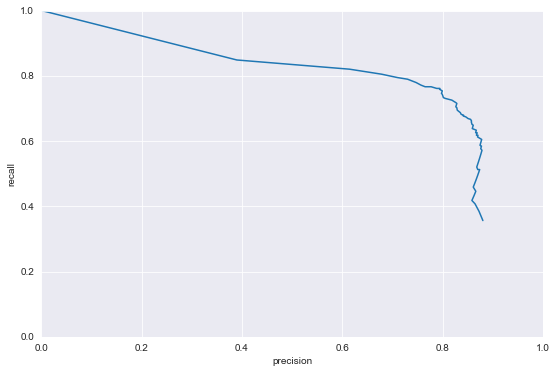

In [7]:
clf = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 10]}

lr, x, y = evaluate_classifier(train_reg, test_reg, clf, params)


Naive Bayes

Best Params: {'priors': (0.6, 0.4)}
Best Score: 0.9470458159297814
F1: 0.11557610241820768
Recall: 0.8333333333333334
Precision: 0.06209400076423385
Threshold: 0.99


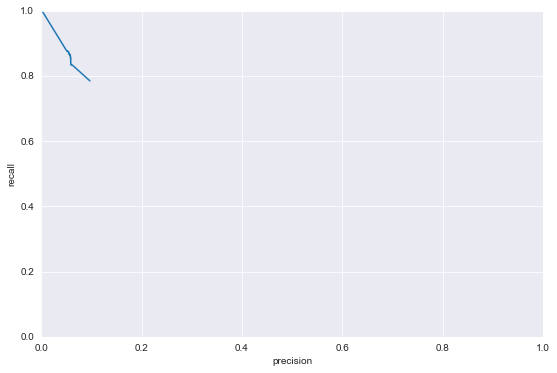

In [8]:
# Alas
priors = [(p, 1-p) for p in np.arange(0.1, 1, 0.1)]
params = {'priors': priors}
clf = GaussianNB()

nb, x, y, = evaluate_classifier(train_reg, test_reg, clf, params)

Random And Extra Random Forests

Best Params: {'class_weight': {0: 0.75, 1: 0.25}, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9729742351631855
F1: 0.8317373461012312
Recall: 0.7794871794871795
Precision: 0.8914956011730205
Threshold: 0.29


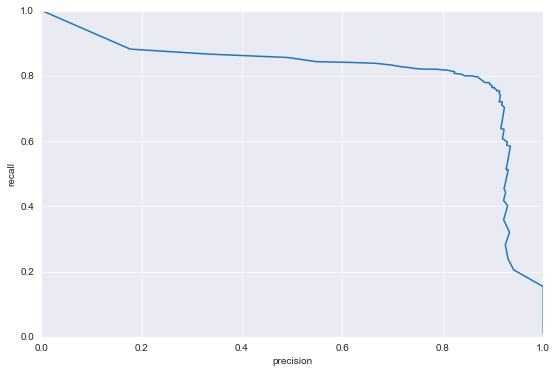

In [9]:
class_weights = [{0:p, 1:1-p} for p in [0.1, 0.25, 0.5, 0.75, 0.9]]
params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
    'class_weight': class_weights
}
clf = RandomForestClassifier(random_state = SEED)


# takes a long time to run ~ 30min!
# {'class_weight': {0: 0.75, 1: 0.25}, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
rf, x, y, = evaluate_classifier(train_reg, test_reg, clf, params)

Best Params: {'class_weight': {0: 0.75, 1: 0.25}, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9691296652838072
F1: 0.835374149659864
Recall: 0.7871794871794872
Precision: 0.8898550724637682
Threshold: 0.18


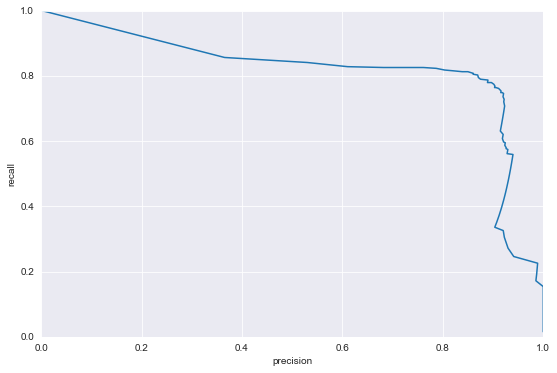

In [10]:
params = {'class_weight': [{0: 0.75, 1: 0.25}], 'criterion': ['entropy'], 'max_depth': [10], 'n_estimators': [250]}
clf = ExtraTreesClassifier(random_state = SEED)

etc, x, y, = evaluate_classifier(train_reg, test_reg, clf, params)

We see that all classifiers acheive a high AUC score on the data. However,
the Naive Bayes classifier suffers from it's simplicity and has very low precision on the target class (fraudulent).

Th Random Forest and Extra Trees Classifiers perform about equally and achieve a higher F1 score than the Logistic Regression.

--------------

### Sampling

We are going to perform the same steps as above except we are going to use both over and undersampling techniques
to create a training dataset.

For undersampling, we are going to create a very small training set where the distribution of classes is equal in the training set.

For oversampling, we will duplicate observations in the minority class (possibly with added gaussian noise) until the sampling distribution is equal.


___Undersample Majority___

In [21]:
train_us, test_us = get_sample(df, n_undersample=300)

Train Distribution of Target Class
1    300
0    300
Name: Class, dtype: int64


Logistic Regression

Best Params: {'C': 0.5, 'penalty': 'l1'}
Best Score: 0.9816444444444444
F1: 0.39999999999999997
Recall: 0.8489583333333334
Precision: 0.26163723916532905
Threshold: 0.99


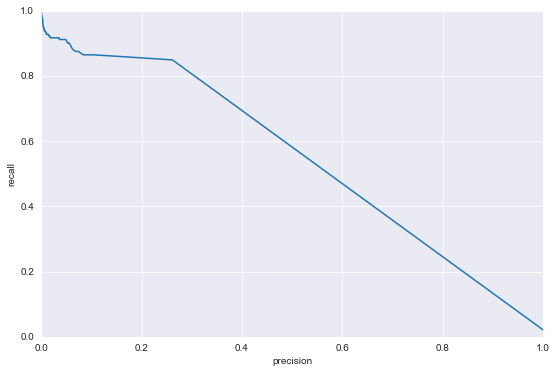

In [22]:
clf = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 10]}

lr_us, x, y = evaluate_classifier(train_us, test_us, clf, params)


Naive Bayes

Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.9569111111111113
F1: 0.050951503990178025
Recall: 0.8645833333333334
Precision: 0.02624920936116382
Threshold: 0.99


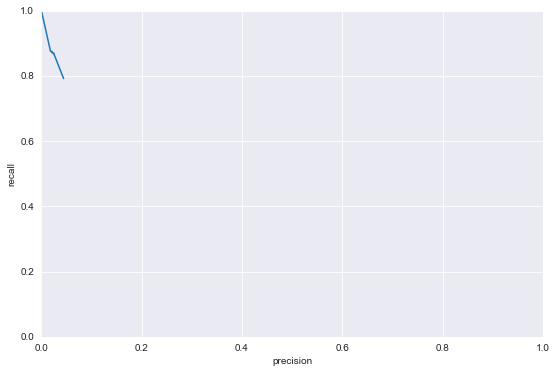

In [23]:
# same problem as before
priors = [(p, 1-p) for p in np.arange(0.1, 1, 0.1)]
params = {'priors': priors}
clf = GaussianNB()

nb_us, x, y, = evaluate_classifier(train_us, test_us, clf, params)

Random Forest and Extra Trees

Best Params: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}
Best Score: 0.9859999999999999
F1: 0.7208121827411168
Recall: 0.7395833333333334
Precision: 0.7029702970297029
Threshold: 0.96


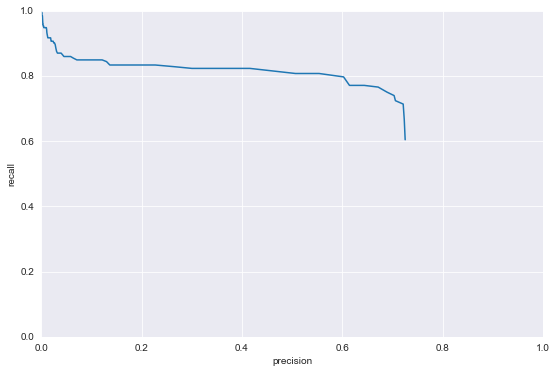

In [24]:
params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
}
clf = RandomForestClassifier(random_state = SEED)


rf_us, x, y, = evaluate_classifier(train_us, test_us, clf, params)

Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Best Score: 0.9865777777777777
F1: 0.6979166666666666
Recall: 0.6979166666666666
Precision: 0.6979166666666666
Threshold: 0.95


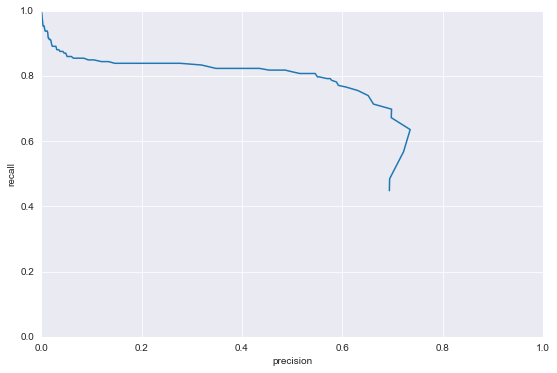

In [25]:
params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
}
clf = ExtraTreesClassifier(random_state = SEED)


et_us, x, y, = evaluate_classifier(train_us, test_us, clf, params)

Undersampling seems to result in poorer performing models all around. This is most likely due to such small sample size for the minority class. Cutting down a dataset of ~ 200K to only 300 samples loses so much information encoded 
in the majority class. The tree models are slightly resiliant to the information loss but still perform much worse than on the full dataset.

___Oversample Minority___

In [16]:
train_os, test_os = get_sample(df, n_oversample=100000)
train_os.reset_index(drop=True, inplace=True)
# randomly add noise to training samples (for minority class)
rows = train_os[train_os.Class==1].sample(frac=0.5).index
cols = train_os.columns[1:30]
train_os.loc[rows, cols] += np.random.randn(len(rows), len(cols))

Train Distribution of Target Class
1    100000
0    100000
Name: Class, dtype: int64


Logistic Regression

Best Params: {'C': 0.01, 'penalty': 'l1'}
Best Score: 0.9856746348000002
F1: 0.6621392190152802
Recall: 0.7926829268292683
Precision: 0.5685131195335277
Threshold: 0.99


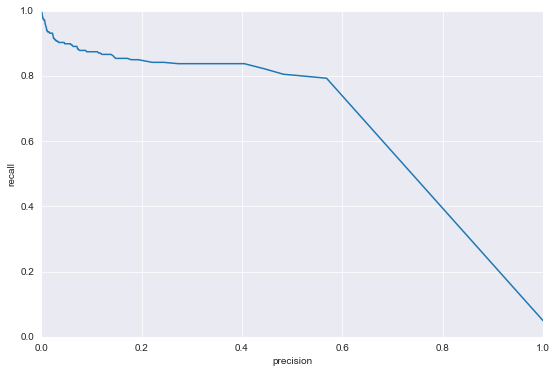

In [17]:
clf = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 10]}

lr_os, x, y = evaluate_classifier(train_os, test_os, clf, params)


Best Params: {'priors': (0.9, 0.09999999999999998)}
Best Score: 0.9748377518
F1: 0.08874943971313312
Recall: 0.8048780487804879
Precision: 0.04696394686907021
Threshold: 0.99


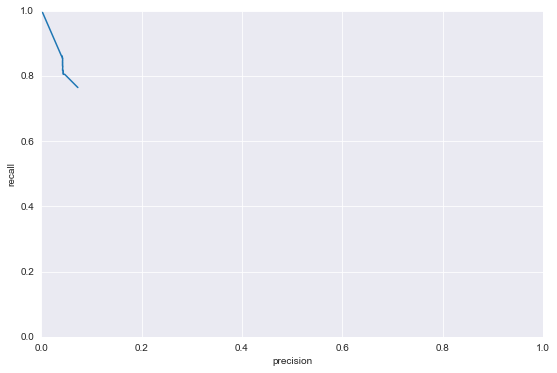

In [18]:
priors = [(p, 1-p) for p in np.arange(0.1, 1, 0.1)]
params = {'priors': priors}
clf = GaussianNB()

nb_os, x, y, = evaluate_classifier(train_os, test_os, clf, params)

Best Params: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 250}
Best Score: 0.9999534796
F1: 0.802660753880266
Recall: 0.7357723577235772
Precision: 0.8829268292682927
Threshold: 0.99


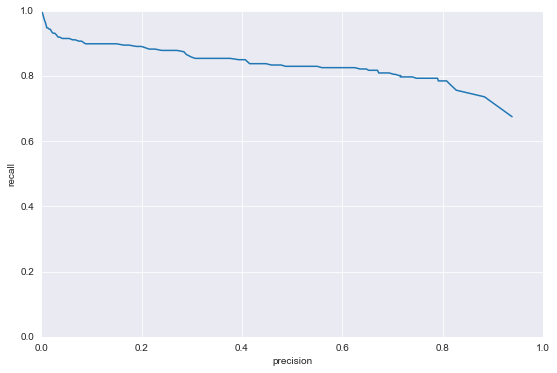

In [19]:
params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
}
clf = RandomForestClassifier(random_state = SEED)


rf_os, x, y, = evaluate_classifier(train_os, test_os, clf, params)

Best Params: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 250}
Best Score: 0.9999478891999999
F1: 0.8067940552016984
Recall: 0.7723577235772358
Precision: 0.8444444444444444
Threshold: 0.95


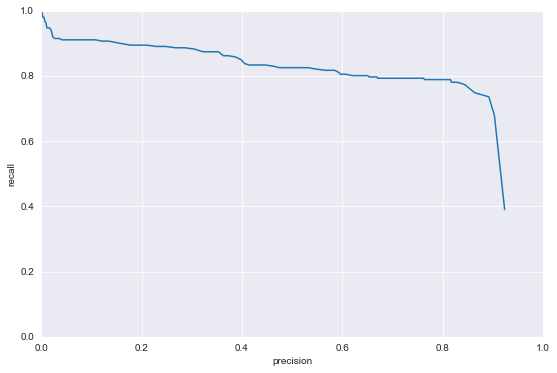

In [20]:
params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
}
clf = ExtraTreesClassifier(random_state = SEED)


et_os, x, y, = evaluate_classifier(train_os, test_os, clf, params)

Over Sampling performs slightly better than undersampling as you still retain enough information to identify the majority class, however it still underperforms compared to the regular sampling. Some tuning of
class distribution would be required to improve the oversampling scores, but this is easily accomplished by tuning the weights in the loss function as set by the `class_weight` parameter in the RandomForestClassifier algorithm.

#### Save the Best Models

In [26]:
from sklearn.externals import joblib

In [29]:
joblib.dump(lr, 'logreg.joblib')
joblib.dump(rf, 'randomForest.joblib')
joblib.dump(etc, 'extraTrees.joblib')

['extraTrees.joblib']